In [1]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from math import sin,cos,pi
import scipy 
from sklearn.metrics import adjusted_rand_score

import seaborn as sns
argk = 5
folder_path = './datas/buque/'
# folder_path2 = './datas/ohss/'
subsize = 20
pcanum = 20
tempnum = 1000

In [2]:
# datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
# datas[datas.obs[datas.obs['layer_guess_reordered']=='Layer1'].index]

In [3]:
# datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
# adata_subset = datas[:tempnum,:]
# datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
# datas = datas[datas.obs[datas.obs['layer_guess_reordered']!='Layer5'].index]
# sc.write('./datas/nature/zise.h5',datas)
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
indices = np.random.choice(datas.n_obs, size=subsize, replace=False)


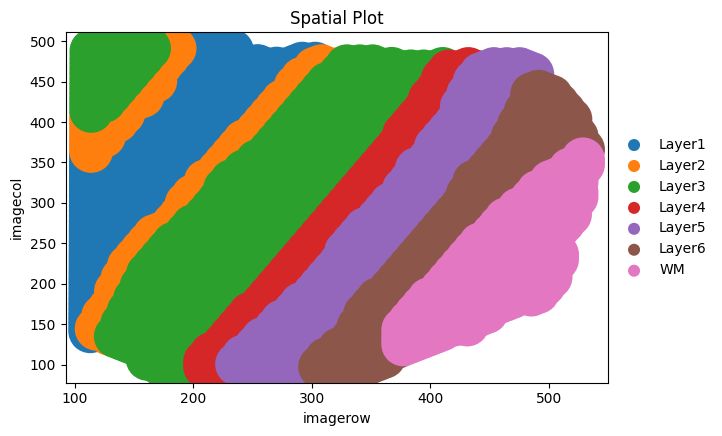

In [4]:
sc.pl.scatter(datas,'imagerow', 'imagecol', color='layer_guess_reordered', title='Spatial Plot',size=4000)

In [5]:
count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

In [6]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
scran = importr('scran')
bluster = importr('bluster')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))
robjects.globalenv.clear()



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 9948 by 4220

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 4220 cells



  |======================================================================| 100%


R[write to console]: Found 37 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 9948 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 9948 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 54.2114 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=====                                                                 |   7%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |===============                                                       |  21%
  |                                                                          

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  4220 
## number of total features:  3969 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  1290  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  1290  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.0396964277485742  
## Calculating kernel matrix
## Finished calculating kernel matrix

In [7]:
adata1 = pd.read_csv(folder_path + 'pca.csv')
adata1 = adata1.set_index(adata1.columns[0])
adata1 = adata1.T
adata1.index = datas.obs.layer_guess_reordered
adata1
# adata1.to_csv(folder_path+'datas.data',header=None);
# adata1.to_csv(folder_path+'datas.csv')

Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
layer_guess_reordered,,,,,,,,,,,,,,,,,,,,
Layer1,-1.742179,-0.050372,0.172844,2.192438,-0.777553,-4.132174,1.636083,1.739748,0.270036,-2.573790,-0.470066,-0.515245,-0.126150,-0.132189,0.190587,0.518257,1.745402,1.127538,-1.012781,0.484063
Layer3,4.208592,-0.188750,-0.850747,-0.732998,1.336927,1.366941,1.130777,-0.353206,-0.060463,0.475084,0.766953,-0.065829,0.621593,0.378397,-0.311984,0.169382,0.094349,0.323343,0.355282,0.735483
Layer1,-8.122478,8.238340,-2.817448,-3.844993,-1.577289,-0.367433,-0.526728,0.374770,1.681578,1.073618,2.758376,0.380476,0.153697,0.705445,-0.267159,-0.631223,-0.152607,0.123091,-0.202371,0.939734
WM,-15.563433,-8.868978,5.220857,-4.435772,2.248321,1.530303,-0.325219,-1.786930,-0.099736,-0.156798,-0.764029,1.235195,0.907501,-0.273418,0.470980,-0.115996,1.055449,-0.224519,2.311397,0.503695
Layer6,2.585480,-1.649134,-0.027134,-0.087575,-3.085096,-1.255844,1.381870,-1.967390,-3.015521,2.926177,0.604160,0.950124,-0.354756,-0.858949,1.690995,-0.863722,-0.497408,0.504896,0.390848,-1.036021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Layer3,3.602209,2.274316,0.859793,-1.887574,1.028837,0.160600,-0.779891,0.649933,0.058348,-0.661194,-0.129109,-0.218892,-0.683292,0.442794,0.489751,0.162806,0.290944,0.404469,0.804577,-0.261684
Layer6,-0.240509,-3.556936,1.898851,-0.375175,-2.388757,0.033545,-0.173732,1.782998,-1.256519,1.225309,-0.382412,-1.119076,-1.028756,0.334160,0.193641,0.333617,-0.223856,0.283033,0.393235,0.034724
WM,-10.261098,-7.747452,1.222923,2.723484,2.947516,-2.285964,-0.099366,1.651121,-2.607931,-0.302745,1.238690,-2.321925,2.557547,2.055927,-2.068037,-1.114067,-1.470836,1.470817,-1.015627,1.710812


In [8]:
adata1.to_csv(folder_path+'ann.csv',index=None)

In [9]:
adata1.T.to_csv(folder_path+'annT.csv',index=None)

In [10]:
args=[ i+1 for i in range(100)];
steps = [i+1 for i in range(10)];
anss = [];
ansss = [];
for argk in args:
    for step in steps:
        matrix = importr('Matrix')
        # igraph = importr('igraph')
        robjects.r("library('igraph')")
        robjects.r(" xys <- read.csv('{}')".format(folder_path+'annT.csv'));
        robjects.r("g <- buildSNNGraph(xys,k={})".format(argk))
        robjects.r("walktrap <- walktrap.community(g,steps={})".format(step))
        robjects.r("clusters <- membership(walktrap)")
        robjects.r("write.csv(clusters,file='{}')".format(folder_path+'cluster.csv'))
        robjects.globalenv.clear()
        meta1 = pd.read_csv(folder_path+'cluster.csv')
        meta1 = meta1.set_index(meta1.columns[0])
        meta1['x'].tolist()
        ari = adjusted_rand_score(meta1['x'].tolist(), datas.obs['layer_guess_reordered'].tolist())
        print("ARI score for {},{}: ".format(argk,step), ari)
        # datas.obs['julei']= meta1['x'].tolist()
        # sc.pl.scatter(datas,'imagerow', 'imagecol', color='julei', title='Spatial Plot',size=4000)
        anss.append(ari)

        ansss.append(meta1['x'].tolist())

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:GenomicRanges’:

    union


R[write to console]: The following object is masked from ‘package:IRanges’:

    union


R[write to console]: The following object is masked from ‘package:S4Vectors’:

    union


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




ARI score for 1,1:  0.006574755808196257
ARI score for 1,2:  0.006574755808196257
ARI score for 1,3:  0.006574755808196257
ARI score for 1,4:  0.006574755808196257
ARI score for 1,5:  0.006574755808196257
ARI score for 1,6:  0.006574755808196257
ARI score for 1,7:  0.006574755808196257
ARI score for 1,8:  0.006574755808196257
ARI score for 1,9:  0.006574755808196257
ARI score for 1,10:  0.006574755808196257
ARI score for 2,1:  0.07653400089647668
ARI score for 2,2:  0.09844917640690093
ARI score for 2,3:  0.08008145887729401
ARI score for 2,4:  0.09406741670913463
ARI score for 2,5:  0.08738216168110706
ARI score for 2,6:  0.08244486825073497
ARI score for 2,7:  0.08304562701672404
ARI score for 2,8:  0.1009473536099117
ARI score for 2,9:  0.09814709799364692
ARI score for 2,10:  0.10003733537786239
ARI score for 3,1:  0.16309477908219863
ARI score for 3,2:  0.1968092516835273
ARI score for 3,3:  0.1482349664795897
ARI score for 3,4:  0.14029071268086768
ARI score for 3,5:  0.145289075

In [23]:
np.save(folder_path+'cluster.npy',(np.array(ansss[indexss])-1).astype('str'))

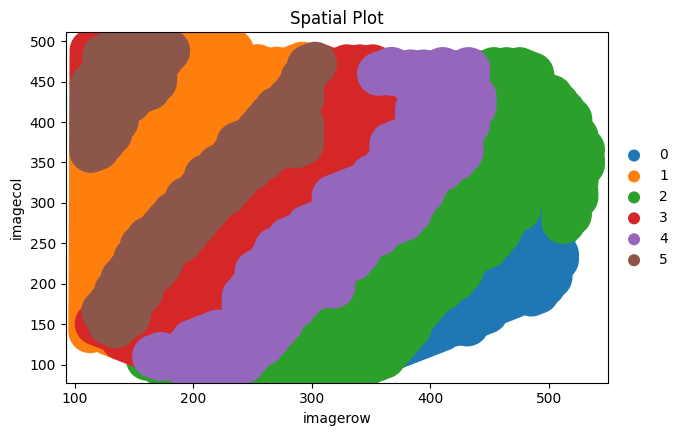

In [11]:
indexss= anss.index(np.array(anss).max())
datas.obs['julei']= (np.array(ansss[indexss])-1).astype('str')
sc.pl.scatter(datas,'imagerow', 'imagecol', color='julei', title='Spatial Plot',size=4000)

In [12]:
adata1.to_csv(folder_path+"datas.data",header=None);
adata1.to_csv(folder_path+"datas.csv");

In [13]:
# get_Hyper_tree(folder_path+'datas.data',1,adata1.shape[1]+1,0,50,model_path=None,save_path=folder_path,c=-1)


In [14]:
adata1.index = ansss[indexss]
adata1.groupby(adata1.index).mean()

Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,-10.098190,-6.289515,2.529854,-0.330850,1.470906,-0.180589,-0.119719,-0.035728,-0.458676,0.182845,0.139806,-0.055256,-0.266528,0.406889,-0.366496,-0.009176,0.194416,0.070322,-0.093712,0.060230
2,-5.331067,4.964400,-1.595576,-0.180147,-0.575764,0.247040,0.001630,0.391069,-0.080431,-0.051188,0.105066,0.063914,0.026743,-0.050351,0.134779,-0.080051,0.057466,-0.016045,0.099697,0.086822
3,1.541350,-3.354396,-0.768824,0.206419,-1.777956,0.047419,-0.631760,-0.287749,-0.110297,0.231138,-0.095013,0.087249,0.160939,-0.032816,0.056925,0.081067,0.027634,-0.019932,0.063778,0.011394
4,3.646162,1.552550,0.775758,-0.615766,1.352093,0.159734,0.219616,-0.059942,-0.233323,0.438171,0.084806,0.134013,0.128982,-0.069533,-0.296155,0.191154,0.212204,0.077992,0.233631,-0.119701
5,3.227504,-1.731686,-1.717394,-0.882518,1.516479,0.341473,0.471013,0.140743,0.221228,-0.246959,0.132110,-0.290422,-0.094724,-0.072339,0.550940,-0.272922,-0.191720,0.072931,-0.245605,0.261360
6,3.019866,3.887349,4.002530,0.968069,-0.481340,-0.200851,-0.840788,0.125556,0.032720,-0.537497,-0.025589,0.214252,0.050777,0.201870,0.447738,-0.363209,-0.007617,-0.138039,-0.154846,0.350380


In [15]:
adata1.groupby(adata1.index).mean().to_csv(folder_path+"datas.data",header=None);
adata1.groupby(adata1.index).mean().to_csv(folder_path+"datas.csv");

./datas/buque/datas.data length:6
Generating all pairs superset


100%|██████████| 1563/1563 [01:05<00:00, 24.02ex/s, loss=0.821878] 


	 Epoch 0 | average train loss: 0.803299
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.13ex/s, loss=0.593212] 


	 Epoch 1 | average train loss: 0.783260
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.98ex/s, loss=1.034125] 


	 Epoch 2 | average train loss: 0.785356
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.11ex/s, loss=0.633347] 


	 Epoch 3 | average train loss: 0.784225
Optimization finished.


100%|██████████| 1563/1563 [01:03<00:00, 24.78ex/s, loss=0.800733] 


	 Epoch 4 | average train loss: 0.778560
Optimization finished.


100%|██████████| 1563/1563 [01:03<00:00, 24.77ex/s, loss=0.725700] 


	 Epoch 5 | average train loss: 0.782672
Optimization finished.


100%|██████████| 1563/1563 [01:03<00:00, 24.52ex/s, loss=0.946010] 


	 Epoch 6 | average train loss: 0.779731
Optimization finished.


100%|██████████| 1563/1563 [01:03<00:00, 24.59ex/s, loss=0.930294] 


	 Epoch 7 | average train loss: 0.783582
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 24.87ex/s, loss=0.759005] 


	 Epoch 8 | average train loss: 0.778881
Optimization finished.


100%|██████████| 1563/1563 [01:03<00:00, 24.55ex/s, loss=0.625580] 


	 Epoch 9 | average train loss: 0.777028
Optimization finished.


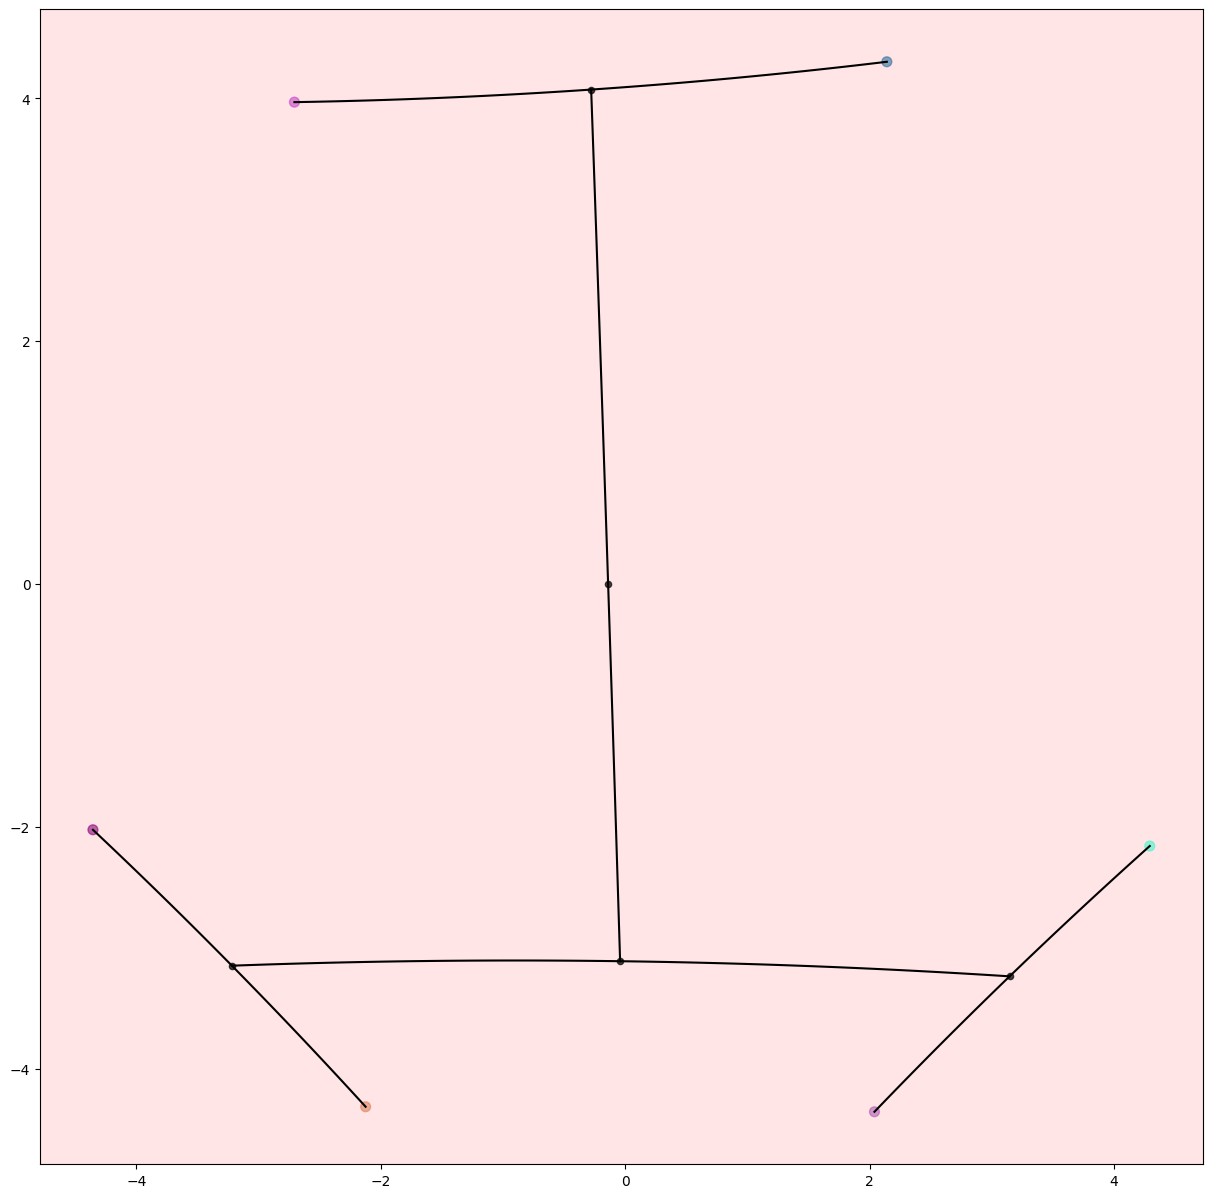

In [16]:
get_Hyper_tree(folder_path+'datas.data',1,adata1.groupby(adata1.index).mean().shape[1]+1,0,10,model_path=None,save_path=folder_path,c=-1)


In [17]:
def search_tree(now,c,merge_list):
    if(len(now.son) != 2):
        return now;
    lson = search_tree(now.son[0],c,merge_list);
    now.son[0] = lson;
    rson = search_tree(now.son[1],c,merge_list);
    now.son[1] = rson

    if(np.linalg.norm(lson.value-rson.value)<=c):
        if(len(lson.son)>1 and len(rson.son)>1):
            pass
        elif(len(lson.son)>1):
            merge_list.append((rson.name,lson.name))
            print(rson.name,lson.name)
            now = rson.copy();
            now.son=[]

            if(len(rson.son)==0):
                now.son.append(lson);
            else:
                now.son.append(lson);
                now.son.append(rson.son);
            # now.son.append(lson);
        else:
            merge_list.append((rson.name,lson.name))
            print(rson.name,lson.name)
            now = lson.copy();
            now.son=[]
            if(len(lson.son)==0):
                now.son.append(rson);
            else:
                now.son.append(lson.son);
                now.son.append(rson);
    return now;

In [18]:
def search_miss_node(now,anslist,smalllist,n):
    if(len(now.son) == 0):
        return now;
    if(len(now.son)==1):
        search_miss_node(now.son[0],anslist,smalllist,n);
        return now;
    lson = search_miss_node(now.son[0],anslist,smalllist,n);
    rson = search_miss_node(now.son[1],anslist,smalllist,n);
    if((int(lson.name)<n and int(rson.name)>n )):
        smalllist.append(int(lson.name))
        anslist.append((lson,rson));
    elif (int(lson.name)>n and int(rson.name)<n ):
        smalllist.append(int(rson.name))
        anslist.append((lson,rson));
    return now
nodes1,n1 = build_hyper_tree(folder_path)
# show_tree(nodes1[0]).show_fig()
anslist = [];
mergelist= []
smalllist = []
search_tree(nodes1[0],1,mergelist)
search_miss_node(nodes1[0],anslist,smalllist,(n1+1)/2)
len(anslist),len(mergelist)
show_tree(nodes1[0]).show_fig()


In [20]:
nodes1,n1 = build_hyper_tree(folder_path)
show_tree(nodes1[0]).show_fig()
nodes2,n2 = build_hyper_tree('./datas/zise/')
show_tree(nodes2[0]).show_fig()
T=tree_alignment(nodes1[0],nodes2[0],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()
G=show_graph(ans,nodes1[0],nodes2[0]);
G.show_fig()

The mininum cost for alignment is 10.977443609022556
The alignment edges list is [('10', '8'), ('9', '6'), ('1', '0'), ('0', '1'), ('8', '5'), ('7', '4'), ('4', '2')]
